In [ ]:
#Use different methods to scale the geographical tree

In [5]:
# %load LuiseUtil.py
import os
import shutil
import math
from ete3 import Tree
from Bio import Phylo
import matplotlib
import matplotlib.pyplot as plt
from codecs import decode
import struct

from Bio import Phylo, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.AlignIO.PhylipIO import PhylipWriter


raxml_ng_path = './../../tools/raxml-ng/build/bin/raxml-ng'
standard_raxml_path = './../../tools/standard-RAxML-master/raxmlHPC-AVX '

tree_dir = 'data/trees/'
alignment_dir = 'data/language_alignments/'
sitelh_dir = 'data/siteLH/'
drawings_dir = 'output/drawings/'
weight_calibration_dir = 'data/weight_calibration/'
site_congruence_dir = 'data/site_congruence/'
lh_dir = 'data/lh/'
indices_dir = 'data/indices/'
deltas_dir = "data/trait_association/delta_statistics/"


#tree_space_name = 'space.trees'
geo_tree_name = "geo_duration.tree"
cognate_tree_name = "cognate_ie_compatible.tree"
cognate_ml_tree_name = "cognate_ml.tree"

morpho_alignment_name = "morpho.phy"



def read_trees_from_ete(tree_set_names):
    trees = []
    for tree_set in tree_set_names:
        l_file = open(tree_dir + tree_set, 'r')
        lines = l_file.readlines()
        for line in lines:
            trees.append(Tree(line))
    return trees

#def read_tree_space_ete():
#    return read_trees_from_ete([tree_space_name])


def eliminate_topological_duplicates_ete(tree_set_names, out_file_name):
    unique_list = []
    tree_set_ete = read_trees_from_ete(tree_set_names)
    i = 0
    for t1 in tree_set_ete:
        unique = True
        for t2 in unique_list:
            rf = rf_distance_ete(t1, t2)
            if rf == 0:
                unique = False
                break
        if unique:
            unique_list.append(t1)
        i = i + 1
    file_name = tree_dir + out_file_name
    with open(file_name, 'w+') as tree_file:
        for tree in unique_list:
            tree_file.write(tree.write()+"\n")
    print(file_name + " created")

def set_neg_branches_zero_ete(tree):
    for node in tree.traverse("postorder"):
        if node.dist < 0:
            node.dist = 0
    return tree

def set_neg_branches_zero(tree_set_name):
    trees = read_trees_from_ete([tree_set_name])
    for tree in trees:
        tree = set_neg_branches_zero_ete(tree)
    file_name = tree_dir + (".".join(tree_set_name.split(".")[:-1])) + ".nonneg.trees"
    with open(file_name, 'w+') as tree_file:
        for tree in trees:
            tree_file.write(tree.write()+"\n")



#def create_tree_space_from(tree_set_names):
#    tree_space_ete = read_trees_from_ete(tree_set_names)
#    file_name = tree_dir + tree_space_name
#    with open(file_name, 'w+') as tree_file:
#        for tree in tree_space_ete:
#            tree_file.write(tree.write()+"\n")
#    print(str(len(tree_space_ete)) + " trees written to " + file_name)

def read_geo_tree_ete():
    return Tree(tree_dir + geo_tree_name)

def read_cognate_tree_ete():
    return Tree(tree_dir + cognate_tree_name)

def rf_distance_ete(t1, t2):
    rf, max_rf, common_leaves, parts_t1, parts_t2,discard_t1, discart_t2 = t1.robinson_foulds(t2, unrooted_trees = True)
    if max_rf == 0:
        print("?!")
        return 0
    return rf/max_rf

def rf_distances_ete(ref_tree, tree_set):
    distances = []
    for tree in tree_set:
        distances.append(rf_distance_ete(ref_tree, tree))
    return distances


def calculate_rf_distances_raxml(ref_tree_name, tree_set_names):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    dir_string = tree_dir + ref_tree_name
    for tree_set in tree_set_names:
        dir_string = dir_string + tree_dir + tree_set
    os.system("cat " + dir_string + " > temp/all.trees")
    os.system(raxml_ng_path + " --rfdist --tree temp/all.trees --prefix temp/foo > temp/bar.txt")
    l_file = open('temp/foo.raxml.rfDistances', 'r')
    lines = l_file.readlines()
    i = 0
    line = lines[i].split("\t")
    distances = []
    while(line[0] == '0'):
        distances.append(float(line[3]))
        i+=1
        line = lines[i].split("\t")
    shutil.rmtree("temp/", ignore_errors=True)
    return distances


def evaluate_lh_raxml(tree_name, alignment_name, optimize = True):
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system(raxml_ng_path + ' --evaluate --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix foo --nofiles' +
              optimize_string + '> out.txt')
    l_file = open('out.txt', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    os.remove("out.txt")
    return lh







def calculate_site_lh_raxml_ete(tree_ete, alignment_name, optimize= True):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    tree_ete.write(outfile="temp/foo.tree")
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system(raxml_ng_path + ' --sitelh --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree temp/foo.tree --prefix temp/foo ' +
              optimize_string + '> temp/bar.txt')
    l_file = open('temp/foo.raxml.log', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    with open('temp/foo.raxml.siteLH' , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    #siteLH = [float(data[i]) for i in range(5, len(data))]
    siteLH = [data[i] for i in range(5, len(data))]
    shutil.rmtree("temp/", ignore_errors=True)
    return [lh, siteLH]




def print_tree_with_phylo(tree_name, save = False):
    tree = Phylo.read(tree_dir + tree_name, "newick")
    tree.ladderize()
    fig = plt.figure(figsize=(10, 10), dpi=100)
    axes = fig.add_subplot(1, 1, 1)
    axes.set_title(tree_name)
    Phylo.draw(tree, axes=axes, do_show=False)
    if save:
        plt.savefig(drawings_dir + tree_name + '.png', dpi=fig.dpi)


def fix_beast_output(tree_set_name):
    beast_file = open(tree_dir + tree_set_name, 'r')
    lines = beast_file.readlines()
    i = 0
    while not lines[i].startswith("\tTranslate"):
        i = i+1
    translate = []
    while not lines[i].startswith(";"):
        if lines[i].endswith(",\n"):
            translate.append(lines[i].split(" ")[-1][:-2])
        else:
            translate.append(lines[i].split(" ")[-1][:-1])
        i=i+1
    i = i+1
    with open(tree_dir + rm_end(tree_set_name) + "_fixed.trees" , 'w+') as fixed_file:
        for j in range(i, len(lines)-1):
            tree = Tree(lines[j].split(" ")[-1])
            for leaf in tree.iter_leaves():
                leaf.name = translate[int(leaf.name)]
            fixed_file.write(tree.write() + "\n")

def rm_end(file_name):
    return '.'.join(file_name.split('.') [:-1])

def lh_file_name(tree_set_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return lh_dir + rm_end(alignment_name) + '_' + rm_end(tree_set_name)  + optimize_string + '.lh'

def lh_raw_file_name(tree_set_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return lh_dir + rm_end(alignment_name) + '_' + rm_end(tree_set_name)  + optimize_string + '_raw.lh'


def site_lh_file_name(tree_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return sitelh_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + optimize_string + '.raxml.siteLH'

def site_lh_raw_file_name(tree_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return sitelh_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + optimize_string + '_raw.raxml.siteLH'

def weight_calibration_file_name(tree_name, alignment_name):
    return weight_calibration_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + '.raxml.weightCalibration'

def site_congruence_file_name(tree_name, alignment_name):
    return site_congruence_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + '.raxml.siteCongruence'

def optimized_tree_file_name(tree_name, alignment_name):
    return tree_dir + rm_end(tree_name) + '_optimized_' + rm_end(alignment_name)  + '.tree'

def ml_trees_file_name(alignment_name, start_trees = ""):
    if start_trees == "":
        return tree_dir + rm_end(alignment_name) + ".raxml.mlTrees"
    else:
        return tree_dir + rm_end(alignment_name) + "_" + start_trees + ".raxml.mlTrees"

def best_tree_file_name(alignment_name, start_trees = ""):
    if start_trees == "":
        return tree_dir + rm_end(alignment_name) + ".raxml.bestTree"
    else:
        return tree_dir + rm_end(alignment_name) + "_" + start_trees + ".raxml.bestTree"

def deltas_file_name(tree_name, alignment_name):
    return deltas_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + '.deltas'


def read_lhs(tree_set_name, alignment_name, optimize):
    lhs = []
    site_lhs = []
    with open(lh_file_name(tree_set_name, alignment_name, optimize) , 'r') as file:
        lines = file.read().split("\n")
    for line in lines[:-1]:
        line_data = line.split("\t")
        lhs.append(float(line_data[0]))
        site_lhs.append([float(el) for el in line_data[1].split(" ")[:-1]])
    return (lhs, site_lhs)

def read_lhs_raw(tree_set_name, alignment_name, optimize):
    lhs = []
    site_lhs = []
    with open(lh_raw_file_name(tree_set_name, alignment_name, optimize) , 'r') as file:
        lines = file.read().split("\n")
    for line in lines[:-1]:
        line_data = line.split("\t")
        lhs.append(float(line_data[0]))
        site_lhs.append([bin_to_float(el) for el in line_data[1].split(" ")[:-1]])
    return (lhs, site_lhs)

def read_site_lh(tree_name, alignment_name, optimize):
    with open(site_lh_file_name(tree_name, alignment_name, optimize) , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    return [float(data[i]) for i in range(5, len(data))]

def read_site_lh_raw(tree_name, alignment_name, optimize):
    with open(site_lh_raw_file_name(tree_name, alignment_name, optimize) , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    return [bin_to_float(data[i]) for i in range(5, len(data))]

def read_weight_calibration(tree_name, alignment_name):
    with open(weight_calibration_file_name(tree_name, alignment_name) , 'r') as file:
        data = file.read().split(" ")
    return [int(data[i]) for i in range(len(data) - 1)]

def read_site_congruence(tree_name, alignment_name):
    with open(site_congruence_file_name(tree_name, alignment_name) , 'r') as file:
        data = file.read().split("\n")
    return [float(data[i].split(" ")[1]) for i in range(len(data) - 1)]

def read_optimized_tree(tree_name, alignment_name):
    return Tree(optimized_tree_file_name(tree_name, alignment_name))

def read_ml_trees(alignment_name, start_trees = ""):
    tree_file = open(ml_trees_file_name(alignment_name, start_trees))
    return [Tree(line[:-1]) for line in tree_file.readlines()]

def read_best_tree(alignment_name, start_trees = ""):
    tree_file = open(best_tree_file_name(alignment_name, start_trees))
    return Tree(tree_file.readlines()[0][:-1])


def read_deltas(alignment_name, tree_name):
    deltas_file = open(deltas_file_name(alignment_name, tree_name))
    return [float(line) for line in deltas_file.readlines()]

def calculate_lhs_raxml(tree_set_name, alignment_name, optimize = False):
    tree_set = read_trees_from_ete([tree_set_name])
    results = [calculate_site_lh_raxml_ete(tree, alignment_name, optimize) for tree in tree_set]
    with open(lh_raw_file_name(tree_set_name, alignment_name, optimize), 'w+') as out_file:
        for result in results:
            out_file.write(str(result[0]))
            out_file.write("\t")
            for site_lh in result[1]:
                #out_file.write(str(site_lh))
                out_file.write(site_lh)
                out_file.write(" ")
            out_file.write("\n")

def calculate_site_lh_raxml(tree_name, alignment_name, optimize= True):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system(raxml_ng_path + ' --sitelh --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix temp/foo ' +
              optimize_string + '> temp/bar.txt')
    l_file = open('temp/foo.raxml.log', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    #os.system("cat temp/foo.raxml.siteLH > " + site_lh_file_name(tree_name, alignment_name, optimize))
    os.system("cat temp/foo.raxml.siteLH > " + site_lh_raw_file_name(tree_name, alignment_name, optimize))
    with open('temp/foo.raxml.siteLH' , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    #siteLH = [float(data[i]) for i in range(5, len(data))]
    siteLH = [data[i] for i in range(5, len(data))]
    shutil.rmtree("temp/", ignore_errors=True)
    return [lh, siteLH]

def calculate_weight_calibration_raxml(tree_name, alignment_name):
    os.system(standard_raxml_path + ' -f u -p 12345 -t ' + tree_dir + tree_name +
              ' -m BINGAMMA -s ' + alignment_dir + alignment_name +
              ' -n calibration > bar.txt')
    os.system('cat RAxML_weights.calibration > '
              + weight_calibration_file_name(tree_name, alignment_name))
    os.remove('bar.txt')
    os.remove('RAxML_weights.calibration')
    os.remove('RAxML_info.calibration')

def calculate_site_congruence_raxml(tree_name, alignment_name):
    os.system(standard_raxml_path + ' -f S -t ' + tree_dir + tree_name +
              ' -m BINGAMMA -s ' + alignment_dir + alignment_name +
              ' -n congruence > bar.txt')
    os.system('cat RAxML_SiteSpecificPlacementBias.congruence > '
              + site_congruence_file_name(tree_name, alignment_name))
    os.remove('bar.txt')
    os.remove('RAxML_SiteSpecificPlacementBias.congruence')
    os.remove('RAxML_info.congruence')

def calculate_optimized_tree_raxml(tree_name, alignment_name):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    os.system(raxml_ng_path + ' --evaluate --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix temp/foo ' + '> out.txt')
    os.system('cat temp/foo.raxml.bestTree > ' + tree_dir + rm_end(tree_name) + "_optimized_" + rm_end(alignment_name) + '.tree')
    shutil.rmtree("temp/", ignore_errors=True)


def calculate_ml_trees_raxml(alignment_name, start_trees = ""):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    if start_trees == "":
        os.system(raxml_ng_path + ' --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --seed 2 --model BIN+G --prefix temp/foo > temp/bar.txt')
    else:
        os.system(raxml_ng_path + ' --msa ' + alignment_dir + alignment_name +
            ' --tree ' + start_trees +
            ' --threads 2 --seed 2 --model BIN+G --prefix temp/foo > temp/bar.txt')
    os.system('cat temp/foo.raxml.mlTrees > ' + ml_trees_file_name(alignment_name, start_trees))
    os.system('cat temp/foo.raxml.bestTree > ' + best_tree_file_name(alignment_name, start_trees))



def get_site_lh(tree_name, alignment_name, optimize):
    if not os.path.isfile(site_lh_file_name(tree_name, alignment_name, optimize)):
        print("Currently not possible, use site_lh_raw")
        #calculate_site_lh_raxml(tree_name, alignment_name, optimize)
    return read_site_lh(tree_name, alignment_name, optimize)

def get_site_lh_raw(tree_name, alignment_name, optimize):
    if not os.path.isfile(site_lh_raw_file_name(tree_name, alignment_name, optimize)):
        calculate_site_lh_raxml(tree_name, alignment_name, optimize)
    return read_site_lh_raw(tree_name, alignment_name, optimize)


def get_weight_calibration(tree_name, alignment_name):
    if not os.path.isfile(weight_calibration_file_name(tree_name, alignment_name)):
        calculate_weight_calibration_raxml(tree_name, alignment_name)
    return read_weight_calibration(tree_name, alignment_name)

def get_site_congruence(tree_name, alignment_name):
    if not os.path.isfile(site_congruence_file_name(tree_name, alignment_name)):
        calculate_site_congruence_raxml(tree_name, alignment_name)
    return read_site_congruence(tree_name, alignment_name)

def get_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    return read_optimized_tree(tree_name, alignment_name)

def get_double_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    optimized_tree_name = optimized_tree_file_name(tree_name, alignment_name).split('/')[-1]
    if not os.path.isfile(optimized_tree_file_name(optimized_tree_name, alignment_name)):
        calculate_optimized_tree_raxml(optimized_tree_name, alignment_name)
    return read_optimized_tree(optimized_tree_name, alignment_name)


def get_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    return read_optimized_tree(tree_name, alignment_name)


def get_lhs(tree_set_name, alignment_name, optimize):
    if not os.path.isfile(lh_file_name(tree_set_name, alignment_name, optimize)):
        #calculate_lhs_raxml(tree_set_name, alignment_name, optimize)
        print("Currently not possible, use lhs_raw")
    return read_lhs(tree_set_name, alignment_name, optimize)

def get_lhs_raw(tree_set_name, alignment_name, optimize):
    if not os.path.isfile(lh_raw_file_name(tree_set_name, alignment_name, optimize)):
        calculate_lhs_raxml(tree_set_name, alignment_name, optimize)
    return read_lhs_raw(tree_set_name, alignment_name, optimize)


def get_ml_trees(alignment_name, start_trees = ""):
    if not os.path.isfile(ml_trees_file_name(alignment_name, start_trees)):
        calculate_ml_trees_raxml(alignment_name, start_trees)
    return read_ml_trees(alignment_name, start_trees)

def get_best_tree(alignment_name, start_trees = ""):
    if not os.path.isfile(best_tree_file_name(alignment_name, start_trees)):
        calculate_ml_trees_raxml(alignment_name, start_trees)
    return read_best_tree(alignment_name, start_trees)


def get_deltas(tree_name, alignment_name):
    if not os.path.isfile(deltas_file_name(alignment_name, tree_name)):
        print("Deltas must be calculated in R!")
    return read_deltas(alignment_name, tree_name)

def average_branch_length(tree_set):
    avg = 0
    cnt = 0
    for tree in tree_set:
        for node in tree.traverse():
            avg = avg + node.dist
            cnt = cnt + 1
    avg = avg / cnt
    return avg



def interval_branch_length(tree_set):
    lower = 1
    upper = 0
    for tree in tree_set:
        for node in tree.traverse():
            lower = min(lower, node.dist)
            upper = max(upper, node.dist)
    return (lower, upper)



def variance_branch_length(tree_set):
    avg = average_branch_length(tree_set)
    var = 0
    cnt = 0
    for tree in tree_set:
        for node in tree.traverse():
            diff = node.dist - avg
            var = var + (diff * diff)
            cnt = cnt + 1
    return var / cnt


def bin_to_float(b):
    return struct.unpack('>d', decode('%%0%dx' % (8 << 1) % int(b, 2), 'hex')[-8:])[0]


def rf_dist_matrix(tree_dict):
    for i, name1 in enumerate(tree_dict):
        for j, name2 in enumerate(tree_dict):
            if name2 <= name1:
                continue
            rf_str = str(rf_distance_ete(tree_dict[name1], tree_dict[name2]))
            print("RF distance of " + name1 + " to " + name2 + ": " + rf_str)





kit_green = "#009682"
kit_orange = "#DF9B1B"
kit_blue = "#0A64AA"
kit_maigreen = "#8CB63C"
kit_yellow = "#FCE500"
kit_red = "#A22223"
kit_lila = "#A3107C"
kit_cyan = "#23A1E0"

names_dict = {
    "cognate_ie_compatible.tree" : "$T_C$",
    "geo_duration.tree" : "$T_G$",

    "morpho.phy" : "$A$",
    "morpho_filtered_indsToUse.phy" : "$\hat{A}$",

    "significant_all_interim.trees" : "$\mathcal{T}_{\t{im}}(\hat{A})$",
    "all_interim.trees" : "$\mathcal{T}_{\t{im}}(A)$",
    "filtered_all_interim.trees" : "$\mathcal{T}_{\t{im}}(A_f)$",

    "significant_all_start.trees" : "$\mathcal{T}_{\t{st}}(\hat{A})$",
    "all_start.trees" : "$\mathcal{T}_{\t{st}}(A)$",
    "filtered_all_start.trees" : "$\mathcal{T}_{\t{st}}(A_f)$"
}



def quartet_distance(tree_name1, tree_name2):
    tree_name1 = os.path.join(tree_dir, tree_name1)
    tree_name2 = os.path.join(tree_dir, tree_name2)
    os.system("./../../tools/qdist/qdist " + tree_name1 + " " + tree_name2 + " >out.txt")
    qdist = float(open("out.txt").readlines()[1].split("\t")[-1])
    os.remove("out.txt")
    return qdist

def quartet_distances(ref_tree_name, tree_set):
    ref_tree_path  = os.path.join(tree_dir, ref_tree_name)
    qdists = []
    for tree in tree_set:
        open("temp.tree", 'w+').write(tree.write())
        os.system("./../../tools/qdist/qdist temp.tree " +  ref_tree_path + " >out.txt")
        qdists.append(float(open("out.txt").readlines()[1].split("\t")[-1]))
    os.remove("out.txt")
    os.remove("temp.tree")
    return qdists








In [6]:
def generate_interval_tree(tree_name, lower, upper):
    tree = Tree(tree_dir + tree_name)
    iv_tree = normalize_to_interval(tree, lower, upper)
    with open('data/trees/' + rm_end(tree_name) + '_scaled_interval=[' + str(lower) + ',' + str(upper) + '].tree',  'w+') as tree_file:
        tree_file.write(iv_tree.write())
        
def generate_average_tree(tree_name, new_avg):
    tree = Tree(tree_dir + tree_name)
    avg_tree = normalize_to_average(tree, new_avg)
    with open('data/trees/' + rm_end(tree_name) + '_scaled_avg=' + str(new_avg)+ '.tree',  'w+') as tree_file:
        tree_file.write(avg_tree.write())

def normalize_to_interval(tree, lower, upper):
    (old_lower, old_upper) = interval_branch_length([tree])
    old_interval_size = old_upper - old_lower
    interval_size = upper - lower
    factor = interval_size / old_interval_size
    first = True
    for node in tree.traverse():
        if first:
            node.dist = 0.0
            first = False
            continue
        node.dist = lower + ((node.dist - old_lower) * factor)
    return tree


def normalize_to_average(tree, new_avg):
    old_avg = average_branch_length([tree])
    factor = new_avg / old_avg
    first = True
    for node in tree.traverse():
        if first:
            first = False
            continue
        node.dist = node.dist * factor
    return tree

        
    

In [7]:
t_cog = Tree(tree_dir + "cognate_ie_compatible.tree")
t_geo = Tree(tree_dir + "geo_duration.tree")
print(rf_distance_ete(t_cog, t_geo))

0.813953488372093


In [8]:
import random
from random import randrange
def sample_branch_lengths(tree, tree_set, seed):
    random.seed(seed)
    brlns = []
    for curr_tree in tree_set:
        first = True
        for node in curr_tree.traverse():
            if first:
                first = False
                continue
            brlns.append(node.dist)
    first = True
    for node in tree.traverse():
        if first:
            first = False
            continue
        node.dist = brlns[randrange(len(brlns))]
    #new_tree_name = rm_end(tree_name) + '_sampled_' + rm_end(tree_set_name)+ "_seed=" + str(seed) + '.tree'
    #with open(tree_dir + new_tree_name,  'w+') as tree_file:
    #    tree_file.write(tree.write())
    #print_tree_with_phylo(new_tree_name)
    return tree
    
def compare_likelihoods_for_samples(tree, tree_set, alignment_name, num, optimize):
    lhs = []
    avgs = []
    #oo_tree = None
    for i in range(num):
        sample_tree = sample_branch_lengths(tree, tree_set, i)
        #optimized_tree = optimization_convergence_behaviour(sample_tree, alignment_name)
        #if not oo_tree == None:
        #    compare_trees(oo_tree, optimized_tree)
        #oo_tree = optimized_tree  
        avgs.append(average_branch_length([sample_tree]))
        lhs.append(calculate_site_lh_raxml_ete(sample_tree, alignment_name, optimize)[0])
    return lhs, avgs

In [9]:
def find_subtree(node):
    if not node.name == '':
        return set([node.name])
    else:
        subtree = set()
        for desc in node.iter_descendants("postorder"):
            subtree = subtree.union(find_subtree(desc))
        return subtree

def nodes_aligned(t1, t2):
    nodes1 = [node for node in t1.traverse()]
    nodes2 = [node for node in t2.traverse()]
    if not len(nodes1) == len(nodes2):
        return False
    for i in range(len(nodes1)):
        if not find_subtree(nodes1[i]) == find_subtree(nodes2[i]):
            return False
    return True




def compare_trees(tree, opt_tree, verbose = False):
    if not nodes_aligned(tree, opt_tree):
        print("Trees not aligned")
        return
    opt_nodes = [node for node in opt_tree.traverse()]
    i = 0
    for node in tree.traverse():
        brlen = node.dist
        opt_brlen = opt_nodes[i].dist
        diff = opt_brlen - brlen
        print(diff)
        i = i + 1

        
def get_optimized_tree_and_lh(tree, alignment_name):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    tree.write(outfile="temp/foo.tree")
    os.system(raxml_ng_path +' --sitelh --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree temp/foo.tree --prefix temp/foo > temp/bar.txt')
    l_file = open('temp/foo.raxml.log', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    optimized_tree = Tree('temp/foo.raxml.bestTree')
    return optimized_tree, lh


def optimization_convergence_behaviour(tree, alignment_name):
    lhs = []
    avgs = []
    avgs.append(average_branch_length([tree]))
    lhs.append(calculate_site_lh_raxml_ete(tree, alignment_name, optimize=False)[0])
    for i in range(10):
        tree, lh = get_optimized_tree_and_lh(tree, alignment_name)
        avgs.append(average_branch_length([tree]))
        lhs.append(lh)
    print(lhs)
    print(avgs)
    return tree

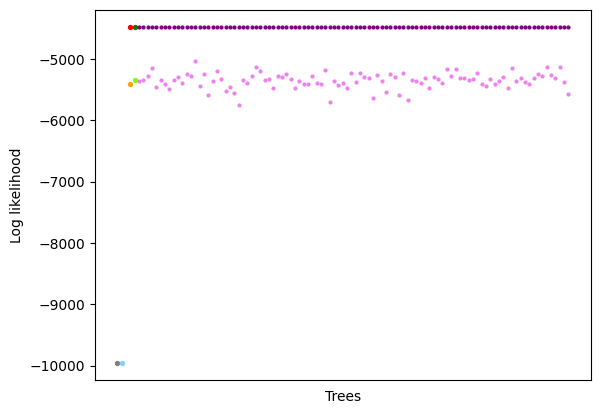

& scaling method & branch length optimization \\
\textcolor{grey}{$\bullet$} & unscaled & no \\
\textcolor{web_lightskyblue}{$\bullet$} & unscaled & yes \\
\textcolor{orange}{$\bullet$} & average & no \\
\textcolor{red}{$\bullet$} & average & yes \\
\textcolor{web_chartreuse}{$\bullet$} & interval & no \\
\textcolor{web_green}{$\bullet$} & interval & yes \\
\textcolor{web_violet}{$\bullet$} & sampling & no \\
\textcolor{web_purple}{$\bullet$} & sampling & yes \\
Average branch length in reference tree set: 0.03324164738562079
Branch Lenght Interval: (0.0;0.457629)


In [10]:
def scaling_full_optimized(tree_name, tree_set_name, alignment_name):
    tree_set = read_trees_from_ete([tree_set_name])
    tree = Tree(tree_dir + tree_name)
    
    unscaled_lh = calculate_site_lh_raxml(tree_name, alignment_name, optimize=False)
    
    optimized_tree = get_optimized_tree(tree_name, alignment_name)
    double_optimized_tree = get_double_optimized_tree(tree_name, alignment_name)
    
    optimized_lh = calculate_site_lh_raxml_ete(optimized_tree, alignment_name, optimize=False)
    double_optimized_lh = calculate_site_lh_raxml_ete(double_optimized_tree, alignment_name, optimize=False)
    
    sample_lhs = compare_likelihoods_for_samples(tree, tree_set, alignment_name, 100, optimize=True)
    
    tree = Tree(tree_dir + tree_name)
    (lower, upper) = interval_branch_length(tree_set)
    iv_tree = normalize_to_interval(tree, lower, upper)
    iv_lh = calculate_site_lh_raxml_ete(iv_tree, alignment_name, optimize=True)[0]
    
    tree = Tree(tree_dir + tree_name)
    avg = average_branch_length(tree_set)
    avg_tree = normalize_to_average(tree, avg)
    avg_lh = calculate_site_lh_raxml_ete(avg_tree, alignment_name, optimize=True)[0]
    
    tree = Tree(tree_dir + tree_name)
    
    fig, ax = plt.subplots()
    plt.scatter([0], [unscaled_lh[0]], label = "unscaled", s=8, color='grey')
    plt.scatter([1], [optimized_lh[0]], label = "unscaled opt", s=8, color='lightskyblue')
    plt.scatter([2], [double_optimized_lh[0]], label = "unscaled double opt", s=8, color='blue')
    plt.scatter([3], [avg_lh], label = "avg opt", s=8, color='red')
    plt.scatter([4], [iv_lh], label ="interval opt", s=8, color='green')
    plt.scatter([i + 5 for i in range(len(sample_lhs[0]))] , sample_lhs[0], label = "sampled opt", s=4, color='purple')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=7)
    plt.xlabel("scaled trees" )
    plt.ylabel("logLH")
    txt= "Original tree: " +  tree_name + "\nAlignment: " + alignment_name + "\nReference Tree Set: " + tree_set_name + "\nAverage Branch Length: " + str(avg) + "\nBranch Lenght Interval: (" + str(lower) + ";" + str(upper) + ")"
    plt.figtext(0.1, -0.3, txt, wrap=True, horizontalalignment='left', fontsize=9)
    plt.show()




def scaling_full(tree_name, tree_set_name, alignment_name, optimize=False):
    tree_set = read_trees_from_ete([tree_set_name])
    tree = Tree(tree_dir + tree_name)
    
    unscaled_lh = calculate_site_lh_raxml(tree_name, alignment_name, optimize=False)
    
    optimized_tree = get_optimized_tree(tree_name, alignment_name)
    double_optimized_tree = get_double_optimized_tree(tree_name, alignment_name)
    
    optimized_lh = calculate_site_lh_raxml_ete(optimized_tree, alignment_name, optimize=False)
    double_optimized_lh = calculate_site_lh_raxml_ete(double_optimized_tree, alignment_name, optimize=False)
    
    sample_lhs = compare_likelihoods_for_samples(tree, tree_set, alignment_name, 100, optimize=False)
    sample_optimized_lhs = compare_likelihoods_for_samples(tree, tree_set, alignment_name, 100, optimize=True)
    
    tree = Tree(tree_dir + tree_name)
    (lower, upper) = interval_branch_length(tree_set)
    iv_tree = normalize_to_interval(tree, lower, upper)
    iv_lh = calculate_site_lh_raxml_ete(iv_tree, alignment_name, optimize=False)[0]
    iv_optimized_lh = calculate_site_lh_raxml_ete(iv_tree, alignment_name, optimize=True)[0]
    
    tree = Tree(tree_dir + tree_name)
    avg = average_branch_length(tree_set)
    avg_tree = normalize_to_average(tree, avg)
    avg_lh = calculate_site_lh_raxml_ete(avg_tree, alignment_name, optimize=False)[0]
    avg_optimized_lh = calculate_site_lh_raxml_ete(avg_tree, alignment_name, optimize=True)[0]
    
    tree = Tree(tree_dir + tree_name)
    
    fig, ax = plt.subplots()
    plt.scatter([0], [unscaled_lh[0]], s=8, color='grey')
    plt.scatter([1], [optimized_lh[0]], s=8, color='lightskyblue')
    #plt.scatter([2], [double_optimized_lh[0]], label = "unscaled double opt", s=8, color='blue')
    plt.scatter([3], [avg_lh],  s=8, color='orange')
    plt.scatter([3], [avg_optimized_lh],  s=8, color='red')
    plt.scatter([4], [iv_lh],  s=8, color='chartreuse')
    plt.scatter([4], [iv_optimized_lh],  s=8, color='green')
    plt.scatter([i + 5 for i in range(len(sample_lhs[0]))] , sample_lhs[0],  s=4, color='violet')
    plt.scatter([i + 5 for i in range(len(sample_lhs[0]))] , sample_optimized_lhs[0],  s=4, color='purple')
    plt.xticks([],[])
    plt.xlabel("Trees" )
    plt.ylabel("Log likelihood")
    plt.show()
    print("& scaling method & branch length optimization \\\\")
    print("\\textcolor{grey}{$\\bullet$} & unscaled & no \\\\")
    print("\\textcolor{web_lightskyblue}{$\\bullet$} & unscaled & yes \\\\")
    print("\\textcolor{orange}{$\\bullet$} & average & no \\\\")
    print("\\textcolor{red}{$\\bullet$} & average & yes \\\\")
    print("\\textcolor{web_chartreuse}{$\\bullet$} & interval & no \\\\")
    print("\\textcolor{web_green}{$\\bullet$} & interval & yes \\\\")
    print("\\textcolor{web_violet}{$\\bullet$} & sampling & no \\\\")
    print("\\textcolor{web_purple}{$\\bullet$} & sampling & yes \\\\")
    
    
    
    print("Average branch length in reference tree set: " + str(avg))
    print("Branch Lenght Interval: (" + str(lower) + ";" + str(upper) + ")")
    


    
    

    
    
    

    
#scaling_full("geo_science_route_duration.tree", "all_plausible.trees", "cognate.phy")
scaling_full("geo_science_route_duration.tree", "all_plausible.trees", "morpho.phy")


         

   

In [6]:

tree_set = read_trees_from_ete(["all_plausible.trees"])
(lower, upper) = interval_branch_length(tree_set)
avg = average_branch_length(tree_set)

tree_name = "geo_science_route.tree"
#generate_interval_tree(tree_name, lower, upper)
#generate_average_tree(tree_name, avg)

tree_name = "geo_science_route_duration.tree"
#generate_interval_tree(tree_name, lower, upper)
#generate_average_tree(tree_name, avg)

0.03324164738562079
0.007850681318681317
